In [8]:
#pip install ydata_profiling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import plotly.express as px
import plotly.graph_objects as go

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score , accuracy_score , f1_score, confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Seaborn Style Graphs
sns.set()
sns.set_style("dark")


In [2]:
# Import data in a dataset
df = pd.read_csv("creditcard.csv")

In [3]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

Since all variables are masked because of the PCA transformation there is not much to be extracted of information looking at the dataset. But the important is in the two last columns, Class, which denotes if a transaction was fraudulent or not, and Amount, that shows the total of the transaction in Euros. A Class 0 represents normal transactions and 1 are transactions that were later identified as frauds.


In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
#Create independent and Dependent Features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


Text(0, 0.5, 'Frequency')

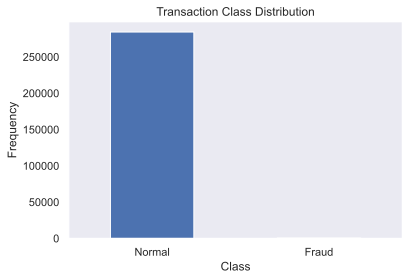

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

LABELS = ["Normal", "Fraud"]

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")


In [7]:
fraud = df[df['Class']==1]

normal = df[df['Class']==0]

print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


It is even difficult to see the bar of frauded transactions. From 284807 transactions only 492 were detected as frauds. That means that, as expected, this is a very unbalanced dataset, with less than 1% being classified as 1.

Let's see the distribution of financial amounts transacted in each situation.

In [8]:
# Set the desired y-axis range
y_axis_range = [0, 350]

# Create the box plot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.ylim(y_axis_range)  # Set the y-axis range
plt.title("Box Plot of Amount by Class")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.show()


It is interesting to see that frauded operations actually have a lower median than real ones. Maybe criminals want to avoid the blocks and additional requirements common in transactions of large amounts. But does that protects them from having their operations identified? Let's see if there is any linear relationship among the variables and the class classification.

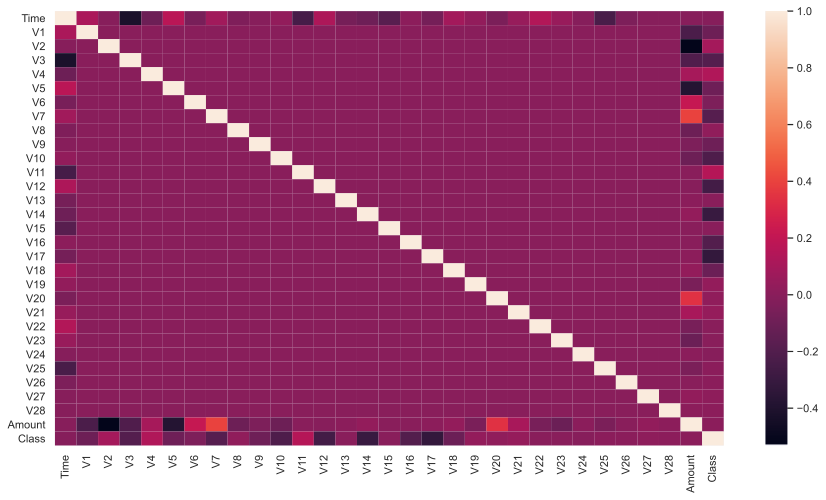

In [9]:
corr = df.corr()

fig = plt.figure(figsize=(15,8))
fig = sns.heatmap(corr,)
plt.show()

Train test split

In [10]:
# Create train and test datasets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(df.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)
(284807, 31)


# Normalization

All variables that came from the PCA transformation seem to range between -100 and 100, while time and amount reach much higher values. This can impact in their relevance to the final model, since their magnitude order is much larger. So the variables will be transformed to have the same range.

(778, 30)
(778,)


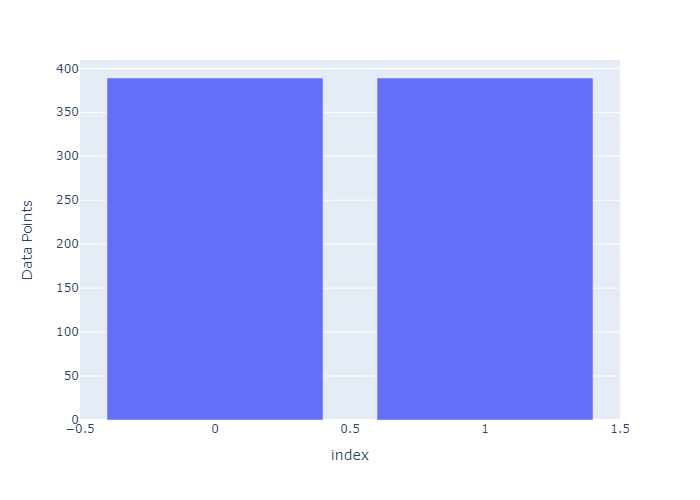

In [11]:
import pandas as pd
import plotly.express as px

rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_resample(X_train, Y_train)

print(X_rus.shape)
print(Y_rus.shape)

counts2 = pd.DataFrame(Y_rus.value_counts())
counts2.columns = ['Data Points']

fig = px.bar(counts2, x=counts2.index, y='Data Points', labels={'x': 'Data Points'})
fig.show('png')

In [12]:
scaler_rus = StandardScaler()
scaler_rus.fit(X_rus)
X_rus_norm = scaler_rus.transform(X_rus)
X_test_rus_norm = scaler_rus.transform(X_test)

X_rus_norm


array([[ 1.24399563,  0.72753467, -0.65684847, ..., -0.04277429,
        -0.1393067 ,  0.18744688],
       [-1.77399826,  0.65554023, -0.50959746, ..., -0.02845244,
        -0.06764767, -0.29527593],
       [ 1.32524302,  0.1810136 , -2.00773968, ..., -0.38978833,
         0.50875348,  4.84175934],
       ...,
       [-0.22288722,  0.17509195,  0.1181922 , ...,  0.30068237,
         0.33581585, -0.32553616],
       [ 0.30078068,  0.0809418 ,  0.59558769, ...,  0.7675727 ,
         0.43415093, -0.32841809],
       [ 0.27662382, -4.25615669,  4.60476123, ..., -4.70950351,
        -1.21276201, -0.3218473 ]])

In [13]:
#pip install pandas plotly

In [14]:
#pip install -U kaleido

In [15]:

def val_model(X, y, classifier, scor, show):

  X = np.array(X)
  y = np.array(y)

  # pipeline = make_pipeline(StandardScaler(), classifier)
  # scores = cross_val_score(pipeline, X, y, scoring = scor)

  scores = cross_val_score(classifier, X, y, scoring = scor)

  if show == True:
    print("Score: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
  
  return scores.mean()
     

In [16]:
# Create models
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()


model_rus = []
score_rus = []

# Check score
for classifier in (rf, dt, svc, lr, xgb):
    model_rus.append(classifier.__class__.__name__)
    score_rus.append(val_model(X_rus_norm, Y_rus, classifier, scor='recall', show=True))

pd.DataFrame(data=score_rus, index=model_rus, columns=['Recall RUS'])
     

Score: 0.89 (+/- 0.02)
Score: 0.89 (+/- 0.03)
Score: 0.87 (+/- 0.02)
Score: 0.90 (+/- 0.02)
Score: 0.91 (+/- 0.03)


Recall RUS
RandomForestClassifier    0.891941
DecisionTreeClassifier    0.886980
SVC                       0.873993
LogisticRegression        0.897070
XGBClassifier             0.907359

# Hyperparameter Tuning

In [17]:
 ## For XGB

In [28]:
xgb = XGBClassifier(learning_rate=0.1, random_state =0)

param_grid = {
    'n_estimators':range(0, 1000, 50)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_norm, Y_rus)

print('Best score: {} for {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score: 0.9075573549257759 for {'n_estimators': 100}


In [29]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state =0)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_norm, Y_rus)

print('Best score: {} for {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score: 0.9074898785425102 for {'max_depth': 3, 'min_child_weight': 3}


In [30]:

xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, min_child_weight=3,random_state =0)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_norm, Y_rus)

print('Best score: {} for {}'.format(grid_result.best_score_, grid_result.best_params_))
     

Best score: 0.9076248313090419 for {'gamma': 0.4}


In [27]:
xgb = XGBClassifier(n_estimators=100, max_depth=3, min_child_weight=2, gamma=0.1, random_state =0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_norm, Y_rus)

print('Best score: {} for {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score: 0.9075573549257759 for {'learning_rate': 0.1}


In [38]:
# after dloing a lot of hit and triallllllll and grid sreach i got these values

In [46]:
xgb = XGBClassifier(learning_rate=0.001, n_estimators=200, max_depth=5, min_child_weight=4, gamma=0.1)
xgb.fit(X_rus_norm, Y_rus)

Y_pred = xgb.predict(X_test_rus_norm)

print(classification_report(Y_test, Y_pred))



              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56859
           1       0.05      0.92      0.10       103

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [47]:
balanced_score = val_model(X_rus, Y_rus, xgb, scor='precision', show=True)

Score: 0.94 (+/- 0.02)


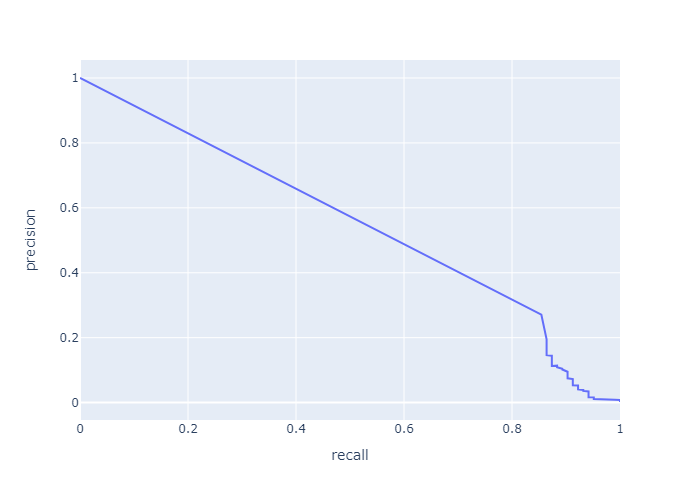

In [49]:
from sklearn.metrics import precision_recall_curve

Y_proba = xgb.predict_proba(X_test_rus_norm)
# Y_proba_unb = xgb_unb.predict_proba(X_test)

# Keep probabilities for the positive outcome only
Y_proba = Y_proba[:, 1]

# Create a dataframe with precision and recall for each threshold
curve = pd.DataFrame(precision_recall_curve(Y_test, Y_proba)).transpose()
curve.columns = ['precision', 'recall', 'threshold']



# Create a precision and recall curve to see the results for different thresholds
fig = px.line(curve, x='recall', y='precision', hover_data=['threshold'])
fig.show('png')

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm
     

array([[-0.76574903, -1.4490894 ,  1.27540024, ...,  2.15529621,
         1.3286969 , -0.2701234 ],
       [ 0.04531031,  0.9775272 ,  0.76599045, ..., -0.08697293,
         0.02732024, -0.33403464],
       [ 0.52353661,  1.01943249, -0.06257967, ..., -0.24598595,
        -0.18264331, -0.14764336],
       ...,
       [ 0.16652052,  0.83003149, -0.89371616, ...,  0.00647705,
        -0.03202768,  0.58608929],
       [-1.28477898,  0.5481842 , -0.13780732, ...,  0.2216492 ,
         0.08498039, -0.17071472],
       [-0.97259002,  0.7178475 , -0.27832863, ...,  0.02534367,
         0.02408304, -0.27807768]])

In [53]:
xgb_unb = XGBClassifier(learning_rate=0.001, n_estimators=200, max_depth=5, min_child_weight=4, gamma=0.1)
xgb = XGBClassifier(learning_rate=0.001, n_estimators=200, max_depth=5, min_child_weight=4, gamma=0.1)
xgb_unb.fit(X_train_norm, Y_train)

Y_pred_unb = xgb_unb.predict(X_test_norm)

print(classification_report(Y_test, Y_pred_unb))



Y_proba_unb = xgb_unb.predict_proba(X_test_norm)

# Keep probabilities for the positive outcome only
Y_proba_unb = Y_proba_unb[:, 1]

# Create a dataframe with precision and recall for each threshold
curve = pd.DataFrame(precision_recall_curve(Y_test, Y_proba_unb)).transpose()
curve.columns = ['precision', 'recall', 'threshold']



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.94      0.80      0.86       103

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



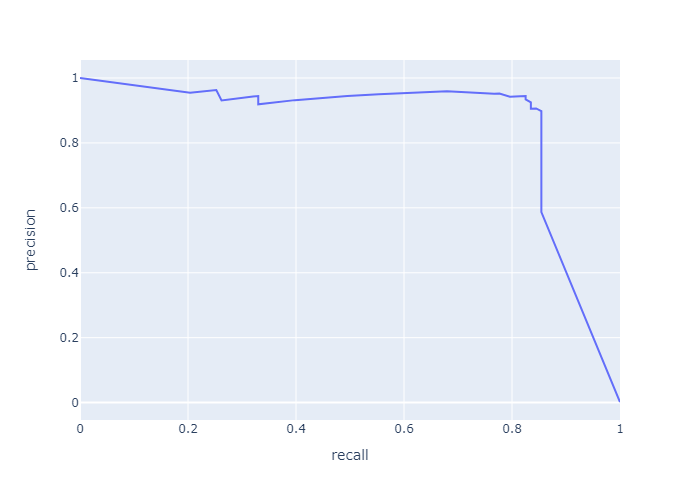

In [54]:
# Create a precision and recall curve to see the results for different thresholds
curve = pd.DataFrame(precision_recall_curve(Y_test, Y_proba_unb)).transpose()
curve.columns = ['precision', 'recall', 'threshold']


fig = px.line(curve, x='recall', y='precision', hover_data=['threshold'])
fig.show('png')

The results obtained with the unbalanced dataset show a better combination of recall in precision for different thresholds. I will choose 48% and check the new classification report.

In [60]:

y_pred_adj = (xgb_unb.predict_proba(X_test_norm)[:,1] >= 0.48).astype(bool) # set threshold as 0.48

print(classification_report(Y_test, y_pred_adj))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.92      0.83      0.88       103

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

